In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score, matthews_corrcoef
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn import linear_model, neighbors
from sklearn.neural_network import MLPClassifier
import pickle, time, glob, os, sys
from skimage.color import rgb2gray
import warnings
% matplotlib inline

In [2]:
# make feature vectors that have been transformed with fft
def read_photo_data(metadata_file="Photos_data.csv", data_col="Class", example_photo="./Fungi Pics/JL1.tif", sample=None):
    '''
    Function to read the photo metadata and extract important variables.
    
    Inputs:
    ------
    metadata_file : (str) Filepath to csv file that corresponds the photo to its classification.
    
    data_col : (str) Column of the file with the classifications.
    
    example_photo : (str) Filepath to an example photo for extracting dimensions.
    
    sample: (int, optional) Number of files to sample to reduce memory requirement.
    
    Outputs:
    -------
    photos_data : (dataframe) Dataframe containing photo filenames and label data.
    
    N : (int) Number of photos in dataset.
    
    labels : (array) Array of the labels associated with each photo.
    
    photo_filenames : (array) Array of the filenames of each photo.
    
    n_classes : (int) The number of unique labels in the dataset.
    
    h, w (int) : The dimensions (height and width) of the photos.
    
    '''
    photos_data = pd.read_csv(metadata_file)#[0:240] # Read the metadata file
    if sample != None:
        photos_data = photos_data.sample(n=sample, random_state=289238547)
    N = len(photos_data) # Find number of photos in dataset
    labels = np.array(photos_data[data_col]) # Extract photo labels from desired column
    photo_filenames = np.array(photos_data.File_name) # Extract filenames of photos
    n_classes = len(np.unique(labels)) # Find number of unique labels
    ex_photo = rgb2gray(plt.imread(example_photo)) # Read and convert an example photo to grayscale
    h, w = ex_photo.shape # Extract photo shape
    return photos_data, N, labels, photo_filenames, n_classes, h, w
def square_transform_rotate_flatten(im, square=True, rotate=True, fft=True):
    '''
    Function to square, fast Fourier transform, rotate, and flatten photos. Returns flat
    FFT image which has horizontal light-to-dark.
    Parameters:
    -----------
    im : (2D array) image to be squared, transformed, rotated if necessary, and flattened.
    
    Outputs:
    --------
    psd2D (2D array) image which has been squared, transformed, rotated if necessary, and flattened.
    '''
    h, w = im.shape[0:2]
    if h > w:
        h, w = w, h
    if fft:
        Fs = np.fft.fft2(im) # Perform fast Fourier transform
        F2 = np.fft.fftshift(Fs)  # Shift low frequencies to center and high frequencies to edges
        psd2D = np.abs(F2) # Remove imaginary component
        if square:
            psd2D_cen = psd2D[:,int((w-h)/2):int((w-(w-h)/2)+1)]
            mid = float(psd2D_cen[int(h/2),int(h/2)])
            ver = sum(psd2D_cen[int((h/2)-2):int((h/2)+3), int((h/2))])-mid
            hor = sum(psd2D_cen[int((h/2)), int((h/2)-2):int((h/2)+3)])-mid
            if abs(ver-hor) > .1 * np.mean([ver,hor]) and (ver>hor) and rotate:
                im = np.rot90(im)
                im = im[int((w-h)/2):int((w-(w-h)/2)+1),:]
            else:
                im = im[:,int((w-h)/2):int((w-(w-h)/2)+1)]
            Fs = np.fft.fft2(im) # Perform fast Fourier transform
            F2 = np.fft.fftshift(Fs)  # Shift low frequencies to center and high frequencies to edges
            psd2D = abs(F2)
        fft_int = psd2D.astype(int) # Convert values to integers to reduce RAM usage
    else:
        fft_int = im.astype(int)
    flat_psd = fft_int.flatten()
    return flat_psd#, im_orig, im, fft_int,
def get_fft_feat_vector(photo_filenames, photo_filepath, best_feats=None, fft=True):
    '''
    Function to create a feature vector of fft transformed photos.
    
    Inputs:
    ------
    photo_filenames : (array or array-like, contains strings) Array of all the filenames of photos to add to feature vector.
    
    photo_filepath : (str) The folder path preceding the photo filenames.
    
    best_feats : (list, or list-like, optional) The list of features to select from original vector.
    
    Outputs:
    -------
    fft_feature_vector : (2D array) The array of the features, size of (n_samples, n_features).
    '''
    start = time.time() # Initiates start time
    fft_feature_vector = [] # Empty list for storing feature vectors
    #print(photo_filenames)
    for i in photo_filenames:
        name = photo_filepath + i # Create filename to match with files in folder
        im = rgb2gray(plt.imread(name)) # Read in photo and convert to grayscale
        flat_psd = square_transform_rotate_flatten(im, square=False, rotate=False, fft=fft)
        if best_feats != None: # If feature selection is occuring
            flat_psd = flat_psd[best_feats] # Select best features
        fft_feature_vector.append(flat_psd) # Append image vector to list
    fft_feature_vector = np.array(fft_feature_vector) # Convert list to array
    Runtime = time.time()-start # Calculate total runtime
    print("Time to make feature vectors:", Runtime)
    print(sys.getsizeof(fft_feature_vector)) # Print size of feature vectors
    return fft_feature_vector

def estimate_best_forest(train_vectors, train_labels, test_vectors, test_labels, stop_score, stop_time, thresh_score=0, extract_features=False, pickled_classifier="hyphal_image_RF_classifier2.obj"):
    '''
    Function to find best Random Forest Classifier through repeated generation of classifiers.
    
    Inputs:
    -------
    train_vectors : A two dimensional array of the features of a dataset to classify after being split into training
    and testing data.
    
    train_labels : A one dimensional array of the labels corresponding to the features in the training dataset.
    
    test_vectors : A two dimensional array of the features of a dataset to classify after being split into training
    and testing data.
    
    test_labels : A one dimensional array of the labels corresponding to the features in the testing dataset.
    
    stop_score : (float) The weighted f1-score which if achieved stops the generation of new classifiers.
    
    stop_time : (integer) The maximum time for whch new classifiers are generated, in seconds.
    
    thresh_score : (float) The threshold f1-score beyond which the features of a classifier are saved.
    
    extract_features : (=True, Boolean, optional) Whether to save best features and return them as output.
    
    pickled_classifier : (="hyphal_image_RF_classifier2.obj", string) File location to store classifier object
    
    Outputs:
    -------
    clf : RandomForestClassifier object wih best score of those generated.
    
    f_scores : List of all the classifiers' weighted f1-scores.
    
    best_feats : List of the features used by classifiers beyond the threshold score.
    '''
    start = time.time() # Initiates start time
    Runtime = 0 # Assigns Runtime variable to zero
    f_scores_int = [] # Creates empty list for storing f1-scores
    best_feats = [] # Creates empty list to store features of best classifiers
    clf = RandomForestClassifier() # Creates instance of classifier object
    #clf = clf.fit(train_vectors, train_labels) # Fits the classifier object
    #pred_labels = clf.predict(test_vectors) # Predicts labels for the testing set
    best_score = 0 #f1_score(test_labels, pred_labels, average='weighted') # Assigns initial best f1-score
    while best_score < stop_score and Runtime < stop_time:
        # Generates classifiers while score is below stop_score and Runtime is less than stop_time
        clf_temp = clf.fit(train_vectors, train_labels) # Finds a new random forest
        pred_labels = clf_temp.predict(test_vectors) # Predicts labels
        temp_score = f1_score(test_labels, pred_labels, average='weighted') # Determines score of new classifier
        f_scores_int.append(temp_score) # Append score to list
        if temp_score > best_score: # If score is better than the previous best
            clf = clf_temp # Temporary classifier saved as new classifier
            pickle.dump(clf_temp, open(pickled_classifier, "wb")) # Store new classifier
            best_score = temp_score # Set new best score
            print(best_score, Runtime) # Print the score and runtime
        if temp_score > thresh_score and extract_features: # If score is above thresh_score and extract_features is true
            best_feats.extend(extract_imp_feats(clf_temp)) # Append best features to list
        Runtime = time.time()-start # Calculate total runtime
    clf = pickle.load(open(pickled_classifier, "rb")) # Load best classifier
    pred_labels = clf.predict(test_vectors) # Predicts the labels using best classifier
    print(classification_report(test_labels, pred_labels)) # Prints the classification report
    print(confusion_matrix(test_labels, pred_labels)) # Prints the confusion matrix
    if extract_features: # If extract features is true
        return clf, f_scores_int, best_feats # Returns the classifier, f1-score list, and best features
    else:
        return clf, f_scores_int # Returns the classifier and f1-score list

def extract_imp_feats(clf):
    '''
    Function to extract the important features of a classifier and return their indexes.
    
    Inputs:
    ------
    clf : RandomForestClassifier object
    
    Outputs:
    -------
    imp_feats_ind : (list) indices of important features
    '''
    feat_imps = clf.feature_importances_ # store all feature importances of the classifier
    imp_feats = np.sum(feat_imps > 0) # Obtains the number of non-zero feature importances
    imp_feat_indices = np.argsort(feat_imps)[-(imp_feats-10):] # Sort and extract the most important feature indexes
    return imp_feat_indices

def plot_important_feats(best_feats, h, w, plot_type='scatter'):
    '''
    Plotting function to plot indexes of a flattened array. Plots as either scatterplot or 2D histogram.
    
    Inputs:
    ------
    best_feats : (array, or array-like) Array of the indexes of points to plot.
    
    h, w : (int) Shape of pre-flattened array.
    
    plot_type : (str, optional) Type of plot to display. Either 'scatter' or 'hist'.
    '''
    best_feats_array = np.array(best_feats) # Converts input to array
    # Acquires coordinates for given indexes
    x = np.floor(best_feats_array/h) # Round down to find column index
    y = np.mod(best_feats_array, w) # Modulus to find row index
    if plot_type == 'scatter': # Plots a scatterplot
        plt.scatter(x, y, s=1)
    elif plot_type == 'hist': # Plots a 2D histogram
        plt.hist2d(x, y, bins=50)
        
def get_f_score_stats(f_scores, percentile = 95):
    '''
    Function for displaying statistics and histogram of a distribution.
    
    Inputs:
    ------
    f_scores : (list, or list-like) List of floats of which to get summary statistics and histogram.
    
    percentile : (float, 0-100, optional) Percentile at which to get the threshold score.
    
    Outputs:
    -------
    thresh_score : (float) Value which falls at the specified percentile.
    '''
    print("Mean:", np.mean(f_scores)) # Print mean of values
    print("Median:", np.median(f_scores)) # Print median of values
    print("Count:", len(f_scores)) # Print number of values
    print("Standard Deviation:", np.std(f_scores)) # Print standard deviation of values
    thresh_score = np.percentile(f_scores, percentile)
    print("Threshold score:", thresh_score)
    plt.hist(f_scores, bins = 30)
    return thresh_score
class rand_for_base():
    def __init__(self, runtime=300):
        self.clf_base = RandomForestClassifier()
        self.f_scores = []
        self.runtime = runtime
class pca_iter_rand_for(rand_for_base):
    def fit(self, train_vec, train_labels, test_vec, test_labels):
        n_components = 20
        self.fft_pca = PCA(n_components=n_components, whiten=True)
        _ = self.fft_pca.fit(train_vec)
        pca_train_vector = self.fft_pca.transform(train_vec)
        pca_test_vector = self.fft_pca.transform(test_vec)
        self.clf_base, self.f_scores = estimate_best_forest(pca_train_vector, train_labels, pca_test_vector, test_labels, 0.99, self.runtime)
        return self.clf_base
    def predict(self, x):
        self.pca_x = self.fft_pca.transform(x)
        return self.clf_base.predict(self.pca_x)
class feat_select_rand_for(rand_for_base):
    def fit(self, train_vec, train_labels, test_vec, test_labels):
        self.best_fs = []
        self.clf_base, self.f_scores = estimate_best_forest(train_vec, train_labels, test_vec, test_labels, 0.99, self.runtime)
        self.threshold = get_f_score_stats(self.f_scores)
        self.best_fs.append(max(self.f_scores))
        self.clf_base, self.f_scores, self.best_feats = estimate_best_forest(train_vec, train_labels, test_vec, test_labels, 0.99, self.runtime*4, thresh_score=self.threshold, extract_features=True)
        self.best_fs.append(max(self.f_scores))
        new_train_vec, new_test_vec = [], []
        if len(self.best_feats) > 0:
            for i in train_vec:
                new_train_vec.append(i[self.best_feats])
                new_test_vec.append(i[self.best_feats])
            self.clf_base, self.f_scores = estimate_best_forest(new_train_vec, train_labels, new_test_vec, test_labels, 0.99, self.runtime)
            self.best_fs.append(max(self.f_scores))
        print(max(self.best_fs))
        return self.clf_base
    def predict(self, x):
        self.new_x = []
        if len(self.best_feats) > 0:
            for i in x:
                self.new_x.append(i[self.best_feats])
        else:
            self.new_x = x
        return self.clf_base.predict(self.new_x)

In [53]:
photos_data, N, labels, photo_filenames, n_classes, h, w = read_photo_data(sample=100)

In [54]:
photos_data

,Strain,Picture,File extension,File_name,Classification (general),Classification (specific),Class,Group
249,Ginkgo-2,_002,.tif,Ginkgo-2_002.tif,Zygomycota,Mortierella,1,Clade 8
495,FL8,_007,.tif,FL8_007.tif,Ascomycota,Lasiodiplodia,2,Ascomycota
66,FC6-2B,NaN,.tif,FC6-2B.tif,Ascomycota,Fusarium oxysporum,2,Ascomycota
377,JL037,_008,.tif,JL037_008.tif,Zygomycota,Mucor,1,Mucor
511,OH1,_008,.tif,OH1_008.tif,Zygomycota,Mucor,1,Mucor
410,JL039,_011,.tif,JL039_011.tif,Zygomycota,Mucor,1,Mucor
251,Ginkgo-2,_004,.tif,Ginkgo-2_004.tif,Zygomycota,Mortierella,1,Clade 8
563,FL6,_015,.tif,FL6_015.tif,Ascomycota,Neopestalotiopsis,2,Ascomycota
351,JL035,_012,.tif,JL035_012.tif,Zygomycota,Mucor,1,Mucor
393,JL038,_009,.tif,JL038_009.tif,Zygomycota,Mucor,1,Mucor


In [4]:
new_labels = []
for i in labels:
    if "Clade" in i:
        new_labels.append(1)
    else:
        new_labels.append(2)
labels = new_labels

In [55]:
fft_feature_vector = get_fft_feat_vector(photo_filenames, './Fungi Pics/', fft=True)
#fft_train_vectors, fft_test_vectors, fft_train_labels, fft_test_labels = train_test_split(fft_feature_vector, 
#                                                                          labels, random_state=324507, test_size=0.50)

Time to make feature vectors: 72.30677795410156
1258291312


In [61]:
pca_feat_arr = np.array(pca_feat_vec).reshape(564, 20)

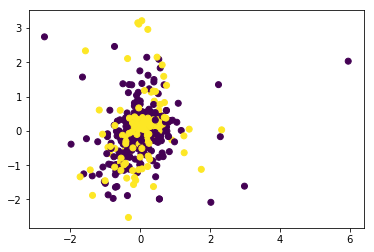

In [77]:
plt.scatter(pca_feat_arr[:,19], pca_feat_arr[:,18], c=labels)

In [65]:
photo_filenames[np.argsort(pca_feat_arr[:,6])]

array(['JL6.tif', 'JL6.tif', 'JL5.tif', 'moss-fen-2B_3.tif', 'JL24.tif',
       'moss-fen-2B_2.tif', 'moss-fen-2B.tif', 'JL036_011.tif',
       'JL036_014.tif', 'JL25_004.tif', 'JL20_9.tif', 'JL24_005.tif',
       'JL24_002.tif', 'JL036_013.tif', 'JL20_4.tif', 'FL5-B_015.tif',
       'stop-3-B_004.tif', 'JL25.tif', 'FL6_005.tif', 'JL24_003.tif',
       'JL039_011.tif', 'FL5-B_012.tif', 'JL23_007.tif', 'JL037_008.tif',
       'FC18-2.tif', 'moss-fen-2A_4.tif', 'moss-pin-2_4.tif',
       'FL8_007.tif', '1233_2.tif', 'FC1-4.tif', 'moss-fen-2A_2.tif',
       'JL039_012.tif', 'JL22_004.tif', 'JL25_003.tif', 'JL036_012.tif',
       'JL20_3.tif', 'BH-VT-1_004.tif', '2nd-sp-c-B_003.tif',
       'FL6_003.tif', 'FL6_009.tif', 'JL038_014.tif', 'JL037_010.tif',
       'JL036_015.tif', 'AD121_2.tif', 'JL25_002.tif', 'P615B.tif',
       'stop-3-B_003.tif', 'OH5_003.tif', 'JL036_010.tif', 'JL034_015.tif',
       'OH5_002.tif', '1230_4.tif', 'JL029_009.tif', '1230_2.tif',
       'JL037_013.tif', 'FL5-

In [41]:
photo_filenames[np.argsort(pca_feat_arr[:,1])]

array(['FC6-1B.tif', 'JL6_2.tif', 'FC18-2_2.tif', 'FC6-1_3.tif',
       'AM1032.tif', 'AM1032_2.tif', 'JL033.tif', 'JL034_008.tif',
       'JL2.tif', 'JL033_004.tif', 'KT4-1 soil isolate.tif',
       'JL034_010.tif', 'CH2-1 soil isolate.tif', 'FC6-1A.tif',
       'JL036_014.tif', 'JL036_001.tif', 'JL034_003.tif', 'JL25_005.tif',
       'JL035_010.tif', 'JL033_005.tif', 'JL036_002.tif',
       'DA-MA-B-3-2.tif', 'JL24_006.tif', 'JL22_007.tif', 'JL033_014.tif',
       'JL034_009.tif', 'JL034_005.tif', 'JL24.tif', 'JL033_009.tif',
       'JL034_006.tif', 'FC1-1_2.tif', 'JL033_008.tif', 'JL1_2.tif',
       'JL033_006.tif', 'JL24_005.tif', 'JL034_012.tif', 'JL036_003.tif',
       'JL037_007.tif', 'JL034_002.tif', 'AD051.tif', 'JL037_009.tif',
       'JL037_006.tif', 'JL037_008.tif', 'GBAus31.tif',
       'septated_ex004.tif', 'JL033_013.tif', 'JL033_011.tif',
       'JL033_007.tif', 'JL029_013.tif', 'FC6-2A.tif', 'JL035_011.tif',
       'JL033_015.tif', 'JL036_012.tif', 'JL034_007.tif', 'JL

Running trial RF+FFT+PCA 1
0.674516523868 0
0.719775641026 0.176530122756958
0.74 0.23836565017700195
0.809942948654 0.39095544815063477
0.8100190019 37.695263385772705
0.818545454545 120.6285183429718
0.819567307692 145.4980239868164
0.82 184.1077880859375
0.829948954059 269.5598714351654
             precision    recall  f1-score   support

          1       0.83      0.82      0.82        49
          2       0.83      0.84      0.83        51

avg / total       0.83      0.83      0.83       100

[[40  9]
 [ 8 43]]
0.829948954059
Running trial RF+FFT+PCA 2
0.66784962406 0
0.687979949875 0.18151426315307617
0.736650563607 0.2293853759765625
0.749774977498 0.3829762935638428
0.810285256731 0.7519896030426025
0.820216780409 27.198355674743652
0.840192076831 64.91749930381775
             precision    recall  f1-score   support

          1       0.90      0.80      0.84        54
          2       0.79      0.89      0.84        46

avg / total       0.85      0.84      0.84       100

0.85641565429492772

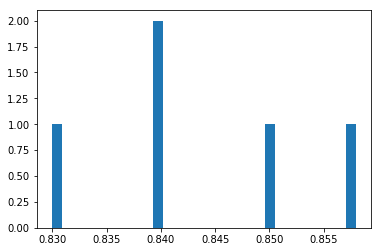

In [12]:
#photos_data, N, labels, photo_filenames, n_classes, h, w = read_photo_data(sample=200)
#fft_feature_vector = get_fft_feat_vector(photo_filenames, './Fungi Pics/', fft=True)
best_scores = []
warnings.filterwarnings("ignore")
for i in range(10):
    print("Running trial RF+FFT+PCA", i+1)
    fft_train_vectors, fft_test_vectors, fft_train_labels, fft_test_labels = train_test_split(fft_feature_vector, labels, test_size=0.50)
    clf = pca_iter_rand_for(runtime=300)
    clf.fit(fft_train_vectors, fft_train_labels, fft_test_vectors, fft_test_labels)
    pred_labels = clf.predict(fft_test_vectors)
    best_scores.append(f1_score(fft_test_labels, pred_labels, average='weighted'))
    print(f1_score(fft_test_labels, pred_labels, average='weighted'))
get_f_score_stats(best_scores)

Running trial FSRF 1
0.577530261418 0
0.600961538462 15.922595262527466
0.670693624262 22.456126928329468
             precision    recall  f1-score   support

          1       0.62      0.71      0.66        45
          2       0.73      0.64      0.68        55

avg / total       0.68      0.67      0.67       100

[[32 13]
 [20 35]]
Mean: 0.53846801917
Median: 0.537419871795
Count: 95
Standard Deviation: 0.0461165410625
Threshold score: 0.615505504459
0.537419871795 0
0.549504950495 12.699046850204468
0.591919191919 15.625220537185669
0.669632553902 61.59231352806091
0.669636963696 118.55800437927246
0.675362318841 1008.2471523284912
             precision    recall  f1-score   support

          1       0.60      0.84      0.70        45
          2       0.81      0.55      0.65        55

avg / total       0.72      0.68      0.68       100

[[38  7]
 [25 30]]
0.391287307808 0
0.40144520273 0.10472440719604492
0.410535336223 0.2533280849456787
0.411478696742 0.9507489204406738


0.58816441102756889

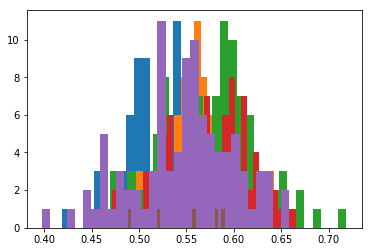

In [13]:
#photos_data, N, labels, photo_filenames, n_classes, h, w = read_photo_data(sample=200)
#fft_feature_vector = get_fft_feat_vector(photo_filenames, './Fungi Pics/', fft=False)
best_scores = []
for i in range(10):
    print("Running trial FSRF", i+1)
    fft_train_vectors, fft_test_vectors, fft_train_labels, fft_test_labels = train_test_split(fft_feature_vector, labels, test_size=0.50)
    clf = feat_select_rand_for(runtime=300)
    clf.fit(fft_train_vectors, fft_train_labels, fft_test_vectors, fft_test_labels)
    pred_labels = clf.predict(fft_test_vectors)
    best_scores.append(f1_score(fft_test_labels, pred_labels, average='weighted'))
    print(f1_score(fft_test_labels, pred_labels, average='weighted'))
get_f_score_stats(best_scores)

Running trial ANN+PCA+FFT 1
0.7
             precision    recall  f1-score   support

          1       0.71      0.69      0.70        51
          2       0.69      0.71      0.70        49

avg / total       0.70      0.70      0.70       100

[[35 16]
 [14 35]]
Running trial ANN+PCA+FFT 2
0.847111523015
             precision    recall  f1-score   support

          1       0.94      0.72      0.82        47
          2       0.80      0.96      0.87        53

avg / total       0.87      0.85      0.85       100

[[34 13]
 [ 2 51]]
Running trial ANN+PCA+FFT 3
0.718636363636
             precision    recall  f1-score   support

          1       0.71      0.65      0.68        46
          2       0.72      0.78      0.75        54

avg / total       0.72      0.72      0.72       100

[[30 16]
 [12 42]]
Running trial ANN+PCA+FFT 4
0.72033721397
             precision    recall  f1-score   support

          1       0.69      0.72      0.70        46
          2       0.75      0.7

0.82175666120616842

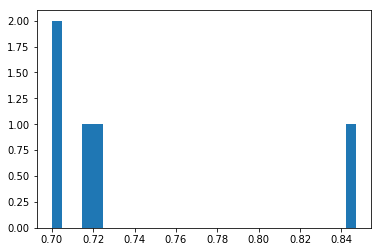

In [8]:
best_scores = []
#photos_data, N, labels, photo_filenames, n_classes, h, w = read_photo_data(sample=10)
#fft_feature_vector = get_fft_feat_vector(photo_filenames, './Fungi Pics/')
for i in range():
    print("Running trial ANN+PCA+FFT", i+1)
    fft_train_vectors, fft_test_vectors, fft_train_labels, fft_test_labels = train_test_split(fft_feature_vector, labels, test_size=0.50)
    n_components = 20
    fft_pca = PCA(n_components=n_components, whiten=True)
    _ = fft_pca.fit(fft_train_vectors)
    pca_train_vectors = fft_pca.transform(fft_train_vectors)
    pca_test_vectors = fft_pca.transform(fft_test_vectors)
    clf = clf = MLPClassifier(solver='lbfgs', alpha=1e-2, hidden_layer_sizes=60)
    clf.fit(pca_train_vectors, fft_train_labels)
    pred_labels = clf.predict(pca_test_vectors)
    best_scores.append(f1_score(fft_test_labels, pred_labels, average='weighted'))
    print(f1_score(fft_test_labels, pred_labels, average='weighted'))
    print(classification_report(fft_test_labels, pred_labels))
    print(confusion_matrix(fft_test_labels, pred_labels))
get_f_score_stats(best_scores)

Running trial ANN+PCA 1
0.763855981417
             precision    recall  f1-score   support

          1       0.82      0.61      0.70        44
          2       0.75      0.89      0.81        56

avg / total       0.78      0.77      0.76       100

[[27 17]
 [ 6 50]]
Running trial ANN+PCA 2
0.72
             precision    recall  f1-score   support

          1       0.68      0.77      0.72        47
          2       0.77      0.68      0.72        53

avg / total       0.73      0.72      0.72       100

[[36 11]
 [17 36]]
Running trial ANN+PCA 3
0.759615846339
             precision    recall  f1-score   support

          1       0.82      0.70      0.76        53
          2       0.71      0.83      0.76        47

avg / total       0.77      0.76      0.76       100

[[37 16]
 [ 8 39]]
Running trial ANN+PCA 4
0.727928388747
             precision    recall  f1-score   support

          1       0.72      0.64      0.68        45
          2       0.73      0.80      0.77   

0.76300795440127278

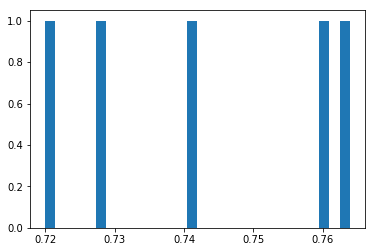

In [9]:
#fft_feature_vector = get_fft_feat_vector(photo_filenames, './Fungi Pics/', fft=False)
best_scores = []
for i in range(5):
    print("Running trial ANN+PCA", i+1)
    fft_train_vectors, fft_test_vectors, fft_train_labels, fft_test_labels = train_test_split(fft_feature_vector, labels, test_size=0.50)
    n_components = 20
    fft_pca = PCA(n_components=n_components, whiten=True)
    _ = fft_pca.fit(fft_train_vectors)
    pca_train_vectors = fft_pca.transform(fft_train_vectors)
    pca_test_vectors = fft_pca.transform(fft_test_vectors)
    clf = clf = MLPClassifier(solver='lbfgs', alpha=1e-2, hidden_layer_sizes=60)
    clf.fit(pca_train_vectors, fft_train_labels)
    pred_labels = clf.predict(pca_test_vectors)
    best_scores.append(f1_score(fft_test_labels, pred_labels, average='weighted'))
    print(f1_score(fft_test_labels, pred_labels, average='weighted'))
    print(classification_report(fft_test_labels, pred_labels))
    print(confusion_matrix(fft_test_labels, pred_labels))
get_f_score_stats(best_scores)

In [10]:
best_scores = []
for i in range(5):
    print("Running trial SVM+PCA", i+1)
    fft_train_vectors, fft_test_vectors, fft_train_labels, fft_test_labels = train_test_split(fft_feature_vector, labels, test_size=0.50)
    start = time.time()
    n_components = 20
    fft_pca = PCA(n_components=n_components, whiten=True)
    _ = fft_pca.fit(fft_train_vectors)
    pca_train_vectors = fft_pca.transform(fft_train_vectors)
    pca_test_vectors = fft_pca.transform(fft_test_vectors)
    param_grid = {'C': [10, 1e2, 1e3, 5e3, 1e4, 5e4, 1e5],
                  'gamma': [0.00001, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
    clf = clf.fit(pca_train_vectors, fft_train_labels)
    pickle.dump(clf, open("hyphal_image_classifier.obj", "wb"))
    end = time.time()
    print("Runtime:", end-start)
    pred_labels = clf.predict(pca_test_vectors)
    print(f1_score(fft_test_labels, pred_labels, average='weighted'))
    print(n_components, classification_report(fft_test_labels, pred_labels))

Running trial SVM+PCA 1
Runtime: 98.48510432243347
0.829948954059
20              precision    recall  f1-score   support

          1       0.83      0.82      0.82        49
          2       0.83      0.84      0.83        51

avg / total       0.83      0.83      0.83       100

Running trial SVM+PCA 2
Runtime: 97.53904461860657
0.710436090226
20              precision    recall  f1-score   support

          1       0.67      0.72      0.69        46
          2       0.75      0.70      0.72        54

avg / total       0.71      0.71      0.71       100

Running trial SVM+PCA 3
Runtime: 99.8544192314148
0.722023283822
20              precision    recall  f1-score   support

          1       0.62      0.80      0.70        41
          2       0.83      0.66      0.74        59

avg / total       0.74      0.72      0.72       100

Running trial SVM+PCA 4
Runtime: 95.68792057037354
0.767695110841
20              precision    recall  f1-score   support

          1       0.82    

In [11]:
#fft_feature_vector = get_fft_feat_vector(photo_filenames, './Fungi Pics/', fft=True)
best_scores = []
for i in range(5):
    print("Running trial SVM+FFT+PCA", i+1)
    fft_train_vectors, fft_test_vectors, fft_train_labels, fft_test_labels = train_test_split(fft_feature_vector, labels, test_size=0.50)
    start = time.time()
    n_components = 20
    fft_pca = PCA(n_components=n_components, whiten=True)
    _ = fft_pca.fit(fft_train_vectors)
    pca_train_vectors = fft_pca.transform(fft_train_vectors)
    pca_test_vectors = fft_pca.transform(fft_test_vectors)
    param_grid = {'C': [10, 1e2, 1e3, 5e3, 1e4, 5e4, 1e5],
                  'gamma': [0.00001, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
    clf = clf.fit(pca_train_vectors, fft_train_labels)
    pickle.dump(clf, open("hyphal_image_classifier.obj", "wb"))
    end = time.time()
    print("Runtime:", end-start)
    pred_labels = clf.predict(pca_test_vectors)
    print(f1_score(fft_test_labels, pred_labels, average='weighted'))
    print(n_components, classification_report(fft_test_labels, pred_labels))

Running trial SVM+FFT+PCA 1
Runtime: 103.61727905273438
0.729755015627
20              precision    recall  f1-score   support

          1       0.71      0.70      0.70        46
          2       0.75      0.76      0.75        54

avg / total       0.73      0.73      0.73       100

Running trial SVM+FFT+PCA 2
Runtime: 92.9703574180603
0.827385709802
20              precision    recall  f1-score   support

          1       0.86      0.72      0.78        43
          2       0.81      0.91      0.86        57

avg / total       0.83      0.83      0.83       100

Running trial SVM+FFT+PCA 3
Runtime: 95.87816047668457
0.76193236715
20              precision    recall  f1-score   support

          1       0.67      0.83      0.74        41
          2       0.86      0.71      0.78        59

avg / total       0.78      0.76      0.76       100

Running trial SVM+FFT+PCA 4
Runtime: 97.84216737747192
0.7
20              precision    recall  f1-score   support

          1       0.6

In [28]:
fft_feature_vector = get_fft_feat_vector(photo_filenames, './Fungi Pics/', fft=False)

Time to make feature vectors: 63.207759618759155
2516582512


Running trial RF+PCA 1
0.289863013699 0
0.378701298701 0.2732701301574707
             precision    recall  f1-score   support

          1       0.00      0.00      0.00        46
          2       0.54      1.00      0.70        54

avg / total       0.29      0.54      0.38       100

[[ 0 46]
 [ 0 54]]
0.378701298701
Running trial RF+PCA 2
0.238439716312 0
0.43786163522 0.1436164379119873
             precision    recall  f1-score   support

          1       0.00      0.00      0.00        41
          2       0.59      1.00      0.74        59

avg / total       0.35      0.59      0.44       100

[[ 0 41]
 [ 0 59]]
0.43786163522
Running trial RF+PCA 3
0.378701298701 0
             precision    recall  f1-score   support

          1       0.00      0.00      0.00        46
          2       0.54      1.00      0.70        54

avg / total       0.29      0.54      0.38       100

[[ 0 46]
 [ 0 54]]
0.378701298701
Running trial RF+PCA 4
0.322281879195 0
0.344503311258 1.5294775962

0.43786163522012578

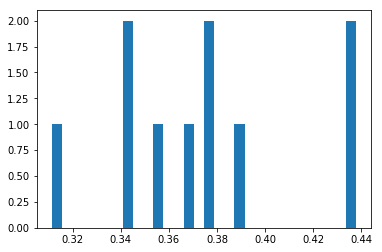

In [29]:
best_scores = []
warnings.filterwarnings("ignore")
for i in range(10):
    print("Running trial RF+PCA", i+1)
    fft_train_vectors, fft_test_vectors, fft_train_labels, fft_test_labels = train_test_split(fft_feature_vector, labels, test_size=0.50)
    clf = pca_iter_rand_for(runtime=300)
    clf.fit(fft_train_vectors, fft_train_labels, fft_test_vectors, fft_test_labels)
    pred_labels = clf.predict(fft_test_vectors)
    best_scores.append(f1_score(fft_test_labels, pred_labels, average='weighted'))
    print(f1_score(fft_test_labels, pred_labels, average='weighted'))
get_f_score_stats(best_scores)

Running trial FSRF 1
0.344503311258 0
             precision    recall  f1-score   support

          1       0.00      0.00      0.00        49
          2       0.51      1.00      0.68        51

avg / total       0.26      0.51      0.34       100

[[ 0 49]
 [ 0 51]]
Mean: 0.344503311258
Median: 0.344503311258
Count: 4
Standard Deviation: 0.0
Threshold score: 0.344503311258
0.344503311258 0
             precision    recall  f1-score   support

          1       0.00      0.00      0.00        49
          2       0.51      1.00      0.68        51

avg / total       0.26      0.51      0.34       100

[[ 0 49]
 [ 0 51]]
0.344503311258
0.344503311258
Running trial FSRF 2
0.311351351351 0
             precision    recall  f1-score   support

          1       0.00      0.00      0.00        52
          2       0.48      1.00      0.65        48

avg / total       0.23      0.48      0.31       100

[[ 0 52]
 [ 0 48]]
Mean: 0.311351351351
Median: 0.311351351351
Count: 4
Standard Devi

0.40461811606115394

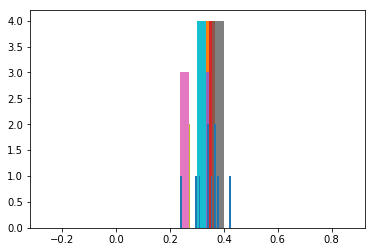

In [30]:
best_scores = []
for i in range(10):
    print("Running trial FSRF", i+1)
    fft_train_vectors, fft_test_vectors, fft_train_labels, fft_test_labels = train_test_split(fft_feature_vector, labels, test_size=0.50)
    clf = feat_select_rand_for(runtime=300)
    clf.fit(fft_train_vectors, fft_train_labels, fft_test_vectors, fft_test_labels)
    pred_labels = clf.predict(fft_test_vectors)
    best_scores.append(f1_score(fft_test_labels, pred_labels, average='weighted'))
    print(f1_score(fft_test_labels, pred_labels, average='weighted'))
get_f_score_stats(best_scores)

Running trial ANN+PCA 1
0.355789473684
             precision    recall  f1-score   support

          1       0.00      0.00      0.00        48
          2       0.52      1.00      0.68        52

avg / total       0.27      0.52      0.36       100

[[ 0 48]
 [ 0 52]]
Running trial ANN+PCA 2
0.367189542484
             precision    recall  f1-score   support

          1       0.00      0.00      0.00        47
          2       0.53      1.00      0.69        53

avg / total       0.28      0.53      0.37       100

[[ 0 47]
 [ 0 53]]
Running trial ANN+PCA 3
0.311351351351
             precision    recall  f1-score   support

          1       0.00      0.00      0.00        52
          2       0.48      1.00      0.65        48

avg / total       0.23      0.48      0.31       100

[[ 0 52]
 [ 0 48]]
Running trial ANN+PCA 4
0.322281879195
             precision    recall  f1-score   support

          1       0.00      0.00      0.00        51
          2       0.49      1.00   

0.36205951152390781

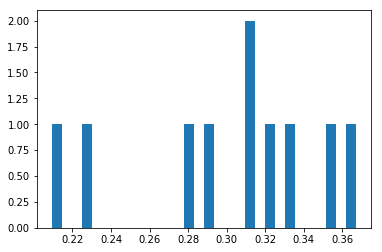

In [32]:
best_scores = []
for i in range(10):
    print("Running trial ANN+PCA", i+1)
    fft_train_vectors, fft_test_vectors, fft_train_labels, fft_test_labels = train_test_split(fft_feature_vector, labels, test_size=0.50)
    n_components = 20
    fft_pca = PCA(n_components=n_components, whiten=True)
    _ = fft_pca.fit(fft_train_vectors)
    pca_train_vectors = fft_pca.transform(fft_train_vectors)
    pca_test_vectors = fft_pca.transform(fft_test_vectors)
    clf = clf = MLPClassifier(solver='lbfgs', alpha=1e-2, hidden_layer_sizes=60)
    clf.fit(pca_train_vectors, fft_train_labels)
    pred_labels = clf.predict(pca_test_vectors)
    best_scores.append(f1_score(fft_test_labels, pred_labels, average='weighted'))
    print(f1_score(fft_test_labels, pred_labels, average='weighted'))
    print(classification_report(fft_test_labels, pred_labels))
    print(confusion_matrix(fft_test_labels, pred_labels))
get_f_score_stats(best_scores)

In [ ]:
best_scores = []
for i in range(10):
    print("Running trial SVM+PCA", i+1)
    fft_train_vectors, fft_test_vectors, fft_train_labels, fft_test_labels = train_test_split(fft_feature_vector, labels, test_size=0.50)
    start = time.time()
    n_components = 20
    fft_pca = PCA(n_components=n_components, whiten=True)
    _ = fft_pca.fit(fft_train_vectors)
    pca_train_vectors = fft_pca.transform(fft_train_vectors)
    pca_test_vectors = fft_pca.transform(fft_test_vectors)
    param_grid = {'C': [10, 1e2, 1e3, 5e3, 1e4, 5e4, 1e5],
                  'gamma': [0.00001, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
    clf = clf.fit(pca_train_vectors, fft_train_labels)
    pickle.dump(clf, open("hyphal_image_classifier.obj", "wb"))
    end = time.time()
    print("Runtime:", end-start)
    pred_labels = clf.predict(pca_test_vectors)
    print(f1_score(fft_test_labels, pred_labels, average='weighted'))
    print(n_components, classification_report(fft_test_labels, pred_labels))

[]

1228PD
1230
1231
1233
1234
1235
1414
2nd-sp-b-2
2nd-sp-c-B
AD051
AD121
AM1032
AM1038
BH-VT-1
CH1-1
CH2-1
CH5-1
D2-hillside-2B
DA-MA-B-1
DA-MA-B-3-2
DA-MA-B-4
DA-T1-1-3
FC1-1
FC1-2
FC1-3
FC1-4
FC11-1
FC18-1
FC18-2
FC2-1
FC4-1
FC5-2
FC5-2A
FC5-2B
FC6-1
FC6-1A
FC6-1B
FC6-2
FC6-2A
FC6-2B
FC7-1
FC7-2
FL4-A
FL4-B
FL5-A
FL5-B
FL6
FL7
FL8
GBAus31
GIB-2B-2B
GIB-5
Ginkgo-2
IG12
IG13
IG2
IG24
IG28
IG3
JL028
JL029
JL033
JL034
JL035
JL036
JL037
JL038
JL039
JL1
JL10
JL11
JL12
JL13
JL14
JL15
JL16
JL17
JL18
JL19
JL2
JL20
JL21
JL22
JL23
JL24
JL25
JL28
JL3
JL4
JL5
JL6
JL7
JL9
JU-1
JU-13
JU-15B
JU-16
JU-17
JU-19
JU-20
JU-22
JU-24
JU-26
JU-27
JU-3
JU-31
JU-33
JU-34
JU-39
JU-4
JU-43
JU-50
JU-8
JU-UNK1
KT3-4
KT3-6
KT3-8
KT4-1
KT4-2
KT4-3B
OH1
OH5
P615B
Pleurotus_1
moss-fen-2A
moss-fen-2B
moss-pin-1
moss-pin-2
moss-pin-3
rotten-stump-1
septated_ex002
septated_ex003
septated_ex004
septated_ex005
septated_ex006
septated_ex1
sp3-above-KIB
stop-3-B
